In [248]:
from sklearn import preprocessing
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

def pcaAnalysis(df, target, features, palette='coolwarm'):
    """
    Description:
        Perform PCA analysis on a dataframe given target and features. Plots the PCA as a scatterplot
        and shows cumulative explained variance ratio for all components.

    Args:
        df (Dataframe): Dataframe on which PCA is to be performed
        target (str): Column label of target value for PCA
        features (list[str]): List of all features from df to consider for PCA
        palette (str): Color palette for hue used in seaborn plot

    Returns:
        None: This function does not return a value.
    """

    # Separating out the features and target
    x = df.loc[:, features].values

    # Standardizing the features
    x = preprocessing.scale(x, with_std=False)

    #PCA
    pca = PCA(n_components=2)
    principalComponents = pca.fit_transform(x)
    principalDf = pd.DataFrame(data = principalComponents, columns = ['PC1', 'PC2'])
    finalDf = pd.concat([principalDf, df[[target]]], axis = 1)

    #Plotting PCA visually
    plt.figure(figsize=(10, 6))
    sns.scatterplot(
        x='PC1',  # Name of the first principal component in principalDf
        y='PC2',  # Name of the second principal component in principalDf
        hue=target,  # Color points based on the target column
        data=finalDf,  # Use finalDf as the data source
        palette=palette,  # Set the color palette
        alpha=0.7  # Set transparency for better visibility
    )

    # Add labels and title
    plt.title('PCA Result Visualization', fontsize=16)  
    plt.xlabel('Principal Component 1', fontsize=14)  
    plt.ylabel('Principal Component 2', fontsize=14)
    plt.legend(title=target, bbox_to_anchor=(1.05, 1), loc='upper left')  # Customize legend
    plt.grid(True)  # Add a grid for easier interpretation
    plt.tight_layout()  # Adjust layout to avoid overlapping elements
    plt.show()  # Display the plot

    # Calculate and plot cumulative explained variance ratio for all components
    # Create new PCA object with all possible components
    n_components = min(len(features), len(df))
    pca_full = PCA(n_components=n_components)
    pca_full.fit(x)
    
    # Calculate cumulative explained variance ratio
    cumulative_variance_ratio = np.cumsum(pca_full.explained_variance_ratio_)
    
    # Create new figure for cumulative variance plot
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(cumulative_variance_ratio) + 1), 
            cumulative_variance_ratio, 
            'bo-', 
            linewidth=2)
    
    # Add reference line at 95% explained variance
    plt.axhline(y=0.95, color='r', linestyle='--', label='95% Explained Variance')
    
    # Customize the plot
    plt.title('Cumulative Explained Variance Ratio by Number of Components', fontsize=16)
    plt.xlabel('Number of Components', fontsize=14)
    plt.ylabel('Cumulative Explained Variance Ratio', fontsize=14)
    plt.grid(True)
    plt.legend()
    
    # Add percentage labels on y-axis
    plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
    
    plt.tight_layout()
    plt.show()

    return x

In [270]:
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.metrics import silhouette_score
from matplotlib.colors import Normalize

def kmeansStats(df, features, max_k=25):
    """
    Description:
        Perform k-means clustering on a dataframe, present graphs of both
        inertial and silhouette scores for all possible k (capped at 25).

    Args:
        df (Dataframe): Dataframe on which clustering is to be performed
        features (list[str]): List of all features from df to consider for clustering
        max_k (int): Maximum number of clusters to consider in elbow method

    Returns:
        None: This function does not return a value.
    """
    # Separating out the features
    x = df.loc[:, features].values

    # Standardizing the features
    x = preprocessing.scale(x, with_std=False)

    # Calculate metrics for different k values
    inertias = []
    silhouette_scores = []
    K = range(2, max_k + 1)
    
    #Create model for every possible k
    for k in K:
        # Create and fit model
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(x)
        
        # Calculate metrics
        inertias.append(kmeans.inertia_)
        silhouette_scores.append(silhouette_score(x, kmeans.labels_))

    # Plot the curves
    plt.figure(figsize=(15, 5))
    
    # Inertia plot
    plt.subplot(1, 2, 1)
    plt.plot(K, inertias, 'bx-')
    plt.xlabel('k (Number of Clusters)')
    plt.ylabel('Inertia')
    plt.title('Elbow Method for Optimal k')
    plt.grid(True)
    
    # Silhouette score plot
    plt.subplot(1, 2, 2)
    plt.plot(K, silhouette_scores, 'rx-')
    plt.xlabel('k (Number of Clusters)')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Score vs Number of Clusters')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()


def kmodel(df, optimal_k, features, palette='coolwarm'):
    """
    Description:
        Perform k-means clustering on a dataframe, determine optimal k using elbow method
        and silhouette scores, and visualize results alongside PCA.

    Args:
        df (Dataframe): Dataframe on which clustering is to be performed
        optimal_k (int): k to use for optimal clustering (see prior method for elbow graph)
        features (list[str]): List of all features from df to consider for clustering
        palette (str): Color palette for visualization

    Returns:
        KMeans: Fitted k-means model with optimal number of clusters
    """
    #Generate and standardize x-values
    x = df.loc[:, features].values
    x = preprocessing.scale(x, with_std=False)

    # Fit final model with optimal k
    final_kmeans = KMeans(n_clusters=optimal_k, random_state=42)
    final_kmeans.fit(x)
    
    # Perform PCA for visualization
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(x)
    
    # Create a colormap and normalize object
    cmap = plt.get_cmap(palette, optimal_k)  
    norm = Normalize(vmin=0, vmax=optimal_k - 1)  # Normalize cluster labels to colormap range

    # Create visualization of clusters in PCA space
    plt.figure(figsize=(10, 6))

    # Scatter plot with explicit color assignment
    colors = cmap(norm(final_kmeans.labels_))
    plt.scatter(X_pca[:, 0], X_pca[:, 1], color=colors, alpha=0.7)

    # Titles and labels
    plt.title(f'K-means Clustering Results (k={optimal_k})\nVisualized in PCA Space', fontsize=16)
    plt.xlabel('First Principal Component', fontsize=14)
    plt.ylabel('Second Principal Component', fontsize=14)

    # Create a legend based on cluster labels
    for i in range(optimal_k):
        plt.scatter([], [], color=cmap(norm(i)), label=f'Cluster {i}')
    plt.legend(title='Clusters', bbox_to_anchor=(1.05, 1), loc='upper left')

    # Grid and layout
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Print summary statistics for each cluster
    cluster_df = pd.DataFrame(x, columns=features)
    cluster_df['Cluster'] = final_kmeans.labels_
    
    print("\nCluster Sizes:")
    print(cluster_df['Cluster'].value_counts().sort_index())
    
    print("\nCluster Centers (Standardized Features):")
    cluster_centers_df = pd.DataFrame(
        final_kmeans.cluster_centers_,
        columns=features,
        index=[f"Cluster {i}" for i in range(optimal_k)]
    )
    print(cluster_centers_df)
    
    return final_kmeans

/var/folders/8j/3gsvq67j7lv_qk7wjp5xhlxw0000gn/T/ipykernel_1529/2943426952.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_header.iloc[1:] = new_header.iloc[1:].astype(int)


,Year,Unprocessed foodstuffs and feedstuffs,Processed foods and feeds,Finished consumer foods,Farm-level cattle,Wholesale beef,Wholesale pork,Wholesale poultry,Farm-level eggs,Farm-level milk,Wholesale dairy,Farm-level soybeans,Wholesale fats and oils,Farm-level fruit,Farm-level vegetables,Farm-level wheat,Wholesale wheat flour
count,50.00000,50.00000,50.000000,50.000000,50.000000,50.000000,50.0000,50.000000,50.00000,50.000000,50.000000,50.00000,50.000000,50.000000,50.000000,50.000000,50.000000
mean,1998.50000,2.73600,2.738000,3.206000,3.094000,3.362000,2.4720,1.458000,5.88200,3.338000,3.200000,2.81200,4.420000,2.688000,3.526000,3.484000,3.192000
std,14.57738,9.78695,6.631338,3.581552,10.971027,9.254031,11.3324,7.718996,30.41016,15.217604,6.731861,17.55096,16.933423,9.505114,12.205716,19.275197,12.112143
min,1974.00000,-17.70000,-8.600000,-2.400000,-19.400000,-16.700000,-23.6000,-18.000000,-59.10000,-30.100000,-14.000000,-24.70000,-23.300000,-35.300000,-19.800000,-36.500000,-23.700000
25%,1986.25000,-3.25000,-1.700000,0.750000,-3.925000,-2.975000,-4.1000,-3.175000,-7.52500,-4.750000,-0.750000,-7.67500,-5.600000,-1.250000,-4.600000,-9.400000,-4.475000
50%,1998.50000,1.60000,1.600000,2.200000,0.550000,2.250000,0.6000,1.450000,1.80000,1.350000,2.100000,0.35000,0.100000,1.900000,2.600000,0.650000,1.450000
75%,2010.75000,5.72500,6.075000,5.175000,7.375000,6.975000,9.8250,4.675000,12.47500,11.325000,8.175000,10.95000,10.925000,7.725000,9.875000,14.425000,9.100000
max,2023.00000,26.70000,18.900000,14.200000,32.400000,28.300000,32.4000,20.400000,163.10000,48.200000,19.100000,47.90000,59.400000,24.700000,51.400000,47.200000,34.400000


,1974,1975,1976,1977,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
count,16.000000,16.000000,16.0000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.00000,16.00000,16.000000,16.00000,16.000000,16.000000,16.00000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.00000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.00000,16.00000
mean,11.475000,0.768750,-3.3125,0.818750,12.775000,11.825000,3.562500,3.300000,-2.750000,2.250000,4.50625,-7.30625,-2.043750,1.17500,8.750000,7.037500,0.88125,-4.718750,-0.643750,3.981250,-0.262500,2.200000,9.762500,-4.16875,-3.987500,-4.725000,1.043750,4.231250,-0.650000,11.156250,9.950000,-2.925000,0.243750,21.781250,14.100000,-14.931250,8.787500,16.300000,1.312500,3.250000,6.487500,-7.006250,-8.506250,4.162500,0.662500,-1.043750,2.137500,18.012500,28.88125,-7.31250
std,18.435817,13.760122,9.3500,11.065756,10.233116,9.930257,5.553242,7.891599,6.773871,5.853204,7.53069,6.39171,8.073658,6.69791,12.511328,9.578579,9.63419,5.077692,13.118433,5.245089,6.216524,5.722587,10.258972,6.69843,11.425053,9.542711,8.184699,6.307426,9.071273,12.696717,9.857315,9.138235,7.723641,18.068839,17.042339,10.597655,8.051739,11.037029,8.119924,7.281941,10.812763,14.499815,15.862134,6.114559,10.046683,10.778248,4.310588,15.634785,38.28558,13.02607
min,-11.300000,-19.700000,-20.9000,-22.500000,-5.800000,-6.500000,-6.800000,-5.200000,-14.500000,-9.400000,-4.00000,-21.10000,-23.100000,-12.00000,-9.400000,-8.400000,-20.00000,-12.100000,-35.300000,-2.100000,-9.300000,-6.000000,-6.500000,-20.80000,-21.500000,-22.500000,-13.500000,-5.800000,-18.800000,-8.100000,-7.300000,-26.500000,-14.800000,2.700000,-4.300000,-36.500000,-0.300000,-4.900000,-19.800000,-6.700000,-12.400000,-28.700000,-59.100000,-2.300000,-8.300000,-34.000000,-4.900000,-6.500000,-5.20000,-28.30000
25%,-3.025000,-9.800000,-9.5500,-0.800000,8.050000,8.075000,-0.825000,-0.750000,-5.950000,0.475000,0.12500,-9.72500,-3.475000,-1.05000,1.250000,3.625000,-2.67500,-6.625000,-2.525000,0.500000,-4.225000,-1.075000,2.525000,-8.85000,-9.150000,-10.525000,-1.750000,1.850000,-6.225000,3.050000,3.900000,-3.675000,-4.125000,7.950000,2.925000,-23.400000,2.900000,11.250000,-2.150000,0.000000,0.875000,-15.175000,-12.050000,0.925000,-3.900000,-4.600000,0.275000,6.050000,14.15000,-16.72500
50%,8.950000,0.350000,-5.6500,2.550000,10.500000,11.400000,3.900000,0.250000,-4.100000,1.250000,2.35000,-7.25000,-1.700000,1.90000,6.350000,6.400000,1.85000,-5.600000,-0.400000,2.200000,1.000000,0.200000,11.400000,-1.85000,-6.400000,-4.750000,1.250000,5.000000,-2.750000,6.250000,10.300000,-1.600000,-1.600000,15.850000,6.000000,-12.600000,7.650000,15.750000,1.700000,1.850000,4.350000,-5.900000,-3.300000,3.050000,-1.900000,0.700000,1.900000,16.500000,18.20000,-7.20000
75%,19.000000,8.675000,2.4000,4.550000,19.400000,16.250000,8.600000,6.050000,0.325000,3.925000,6.10000,-1.20000,2.975000,3.65000,11.250000,8.925000,6.12500,-3.025000,4.025000,7.025000,1.750000,4.375000,15.850000,0.97500,4.150000,0.625000,6.775000,6.200000,6.650000,20.975000,15.850000,2.400000,7.625000,27.875000,21.875000,-8.300000,12.400000,23.525000,5.750000,3.650000,18.125000,-1.025000,-1.475000,6.450000,0.750000,2.650000,2.300000,25.425000,27.77500,-1.65000
max,59.400000,32.400000,12.1000,18.800000,32.400000,30.500000,11.600000,26.900000,15.100000,16.300000,26.20000,1.20000,12.100000,15.10000,41.300000,35.000000,22.60000,10.000000,24.100000,17.600000,16.200000,13.200000,25.600000,2.60000,15.800000,14.500000,18.100000,21.500000,14.500000,37.900000,28.000000,10.200000,13.800000,61.200000,47.900000,2.100000,27.100000,37.500000,13.

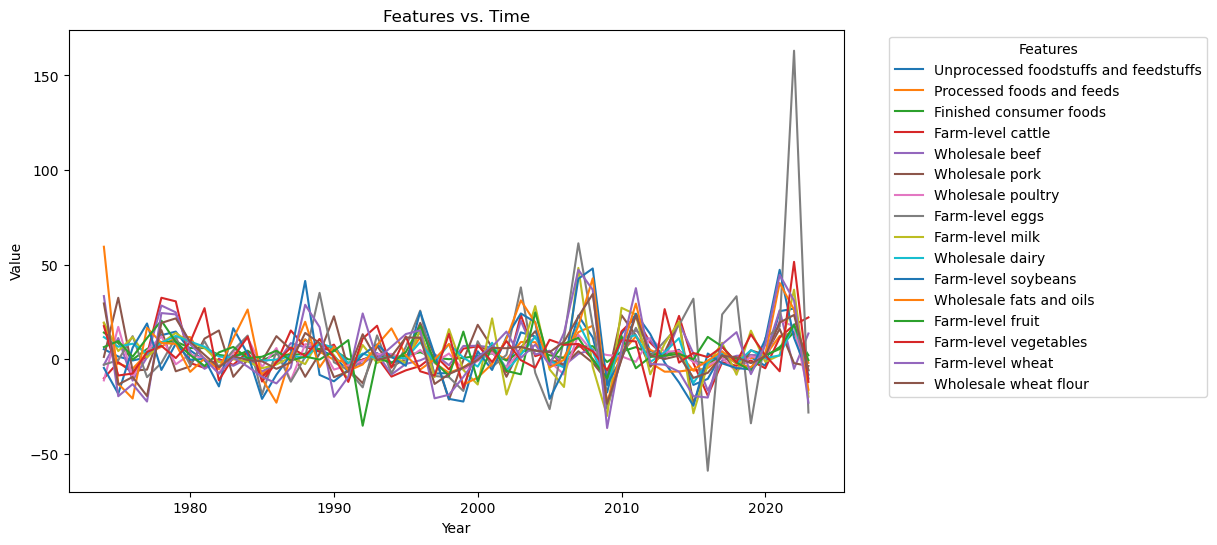

In [256]:
import pandas as pd

#Get raw data from excel
raw_df = pd.read_excel('historicalppi.xlsx')
clean_df = raw_df.copy()

#Process and clean the raw df
new_header = clean_df.iloc[0]
new_header.iloc[1:] = new_header.iloc[1:].astype(int)
clean_df.columns = new_header
clean_df.drop([0,17,18,19], inplace=True)
clean_df.set_index(clean_df.columns[0], drop=True, inplace=True)

'''Create ItemDF from cleanDF'''
#Reset Index to be based off of the item and fill N/A values
itemIndexdf = clean_df.copy()
itemIndexdf.at['Farm-level eggs',1983] = 4.6
itemIndexdf.at['Farm-level eggs',1984] = 12.4
itemIndexdf.reset_index(inplace=True)

'''Create yearDF from cleanDF'''
#Set Producer Price Index item as columns rather than rows
yearIndexdf = clean_df.copy()
yearIndexdf = yearIndexdf.T
yearIndexdf.reset_index(inplace=True)

#Change Header Row
header = list(df.columns.copy())
header[0] = 'Year'
header[1] = 'Unprocessed foodstuffs and feedstuffs'
yearIndexdf.columns = header

#Enforce integer typing for year
yearIndexdf['Year'] = yearIndexdf['Year'].astype(int)

#Need to fill farm-level eggs for 1983 (6.6) & 1984 (14.4)
#.at has to use index and header vals .iat uses only integers
yearIndexdf.at[9,'Farm-level eggs'] = 4.6
yearIndexdf.at[10,'Farm-level eggs'] = 12.4

'''Describe the data using statistics'''
display(yearIndexdf.describe())
display(itemIndexdf.describe())

'''Initial Graph of the data'''
# Graphing of line plots for each item on the same graph with different colors
plt.figure(figsize=(10, 6))  # Create a single figure
for i in range(1, len(yearIndexdf.columns)):  
    sns.lineplot(data=yearIndexdf, x='Year', y=yearIndexdf.columns[i], label=yearIndexdf.columns[i])

plt.title("Features vs. Time")
plt.legend(title="Features", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel("Year")
plt.ylabel("Value")
plt.show() 

,Year,Unprocessed foodstuffs and feedstuffs,Processed foods and feeds,Finished consumer foods,Farm-level cattle,Wholesale beef,Wholesale pork,Wholesale poultry,Farm-level eggs,Farm-level milk,Wholesale dairy,Farm-level soybeans,Wholesale fats and oils,Farm-level fruit,Farm-level vegetables,Farm-level wheat,Wholesale wheat flour
0,1974,5.2,18.9,14.0,-10.2,-3.1,1.1,-11.3,-3.0,19.3,11.6,-4.7,59.4,6.3,17.4,33.3,29.4
1,1975,1.3,-2.4,8.4,-1.7,11.1,32.4,17.0,-0.6,4.2,6.5,-18.4,-13.1,9.5,-8.7,-19.7,-13.5
2,1976,-0.8,-5.1,-0.3,-7.1,-11.4,-6.2,-9.7,12.1,11.6,8.1,6.0,-20.9,1.2,-7.7,-13.3,-9.5
3,1977,0.9,2.8,5.3,2.3,0.9,-5.6,4.3,-9.6,0.8,3.0,18.8,16.5,11.1,3.7,-22.5,-19.6
4,1978,12.6,6.5,9.0,32.4,28.3,15.3,12.0,-2.1,8.4,8.6,-5.8,8.5,20.3,7.0,24.3,19.1
5,1979,14.5,11.4,9.3,30.5,24.7,-6.5,-2.8,11.4,13.8,12.2,8.1,8.0,9.0,0.5,23.6,21.5
6,1980,4.6,11.6,5.8,-2.1,3.2,-3.9,2.5,-3.1,8.5,9.2,-0.4,-6.8,2.1,8.9,7.8,9.1
7,1981,-0.7,-0.9,5.8,-4.7,-5.2,10.8,0.0,9.4,5.9,6.5,0.0,0.3,-3.7,26.9,0.2,2.2
8,1982,-3.8,-4.4,2.2,0.0,-0.7,15.1,-7.6,-4.5,-1.7,1.3,-14.5,-5.4,3.5,-11.3,-7.8,-4.4
9,1983,1.8,3.6,1.0,-3.1,-3.6,-9.4,3.7,4.6,-0.2,0.7,16.3,11.0,6.4,1.0,0.7,1.5


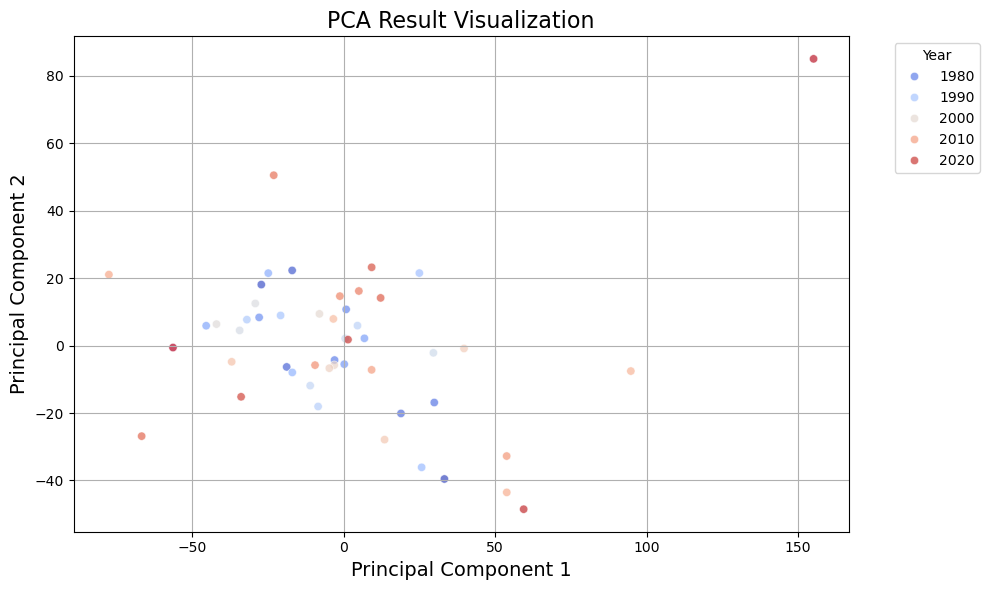

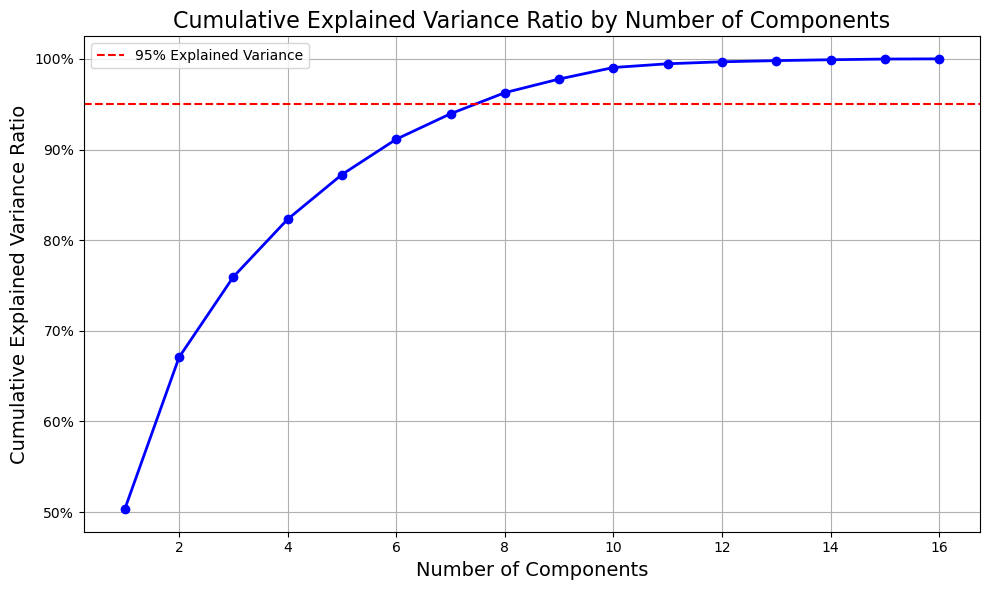

,Producer Price Index item,1974,1975,1976,1977,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
0,Unprocessed foodstuffs and feedstuffs,5.2,1.3,-0.8,0.9,12.6,14.5,4.6,-0.7,-3.8,1.8,2.8,-9.5,-1.7,3.2,10.3,4.8,1.7,-6.7,-0.4,3.1,-1.8,-0.7,14.8,-7.7,-7.4,-5.0,1.5,5.9,-6.2,14.1,11.9,-3.4,-2.8,23.0,11.4,-17.7,13.3,23.6,4.2,1.9,4.9,-13.7,-10.5,2.9,-1.9,0.9,-3.6,25.3,26.7,-10.3
1,Processed foods and feeds,18.9,-2.4,-5.1,2.8,6.5,11.4,11.6,-0.9,-4.4,3.6,2.0,-7.9,-1.1,3.1,10.4,3.9,-0.4,-1.9,-0.4,1.8,1.9,0.0,11.6,-2.1,-7.3,-4.4,0.5,3.8,-0.3,9.0,8.9,-2.4,1.0,14.2,17.6,-8.6,3.4,11.9,4.8,1.4,3.2,-6.2,-4.7,1.0,0.7,0.5,1.8,12.2,14.0,-2.0
2,Finished consumer foods,14.0,8.4,-0.3,5.3,9.0,9.3,5.8,5.8,2.2,1.0,4.4,-0.8,2.6,2.1,2.8,5.4,4.8,-0.2,-0.6,1.9,0.9,1.7,3.6,0.7,-0.1,0.6,1.6,3.0,-0.8,4.1,4.7,2.0,0.6,6.6,6.8,-1.6,3.9,6.3,2.7,2.2,4.4,-1.3,-2.4,1.3,0.1,2.0,1.3,6.3,14.2,2.0
3,Farm-level cattle,-10.2,-1.7,-7.1,2.3,32.4,30.5,-2.1,-4.7,0.0,-3.1,3.7,-9.3,-2.1,15.1,6.5,3.9,7.6,-5.5,-0.3,1.1,-9.3,-6.0,-3.7,2.2,-5.5,5.5,6.7,4.1,-7.0,23.3,1.5,4.2,-4.0,7.8,0.0,-10.4,14.6,22.1,8.6,1.4,22.8,-2.2,-19.4,-1.7,-3.6,-0.8,-4.9,11.3,18.1,22.0
4,Wholesale beef,-3.1,11.1,-11.4,0.9,28.3,24.7,3.2,-5.2,-0.7,-3.6,0.3,-6.6,-2.4,8.4,6.2,7.4,6.5,-3.3,-2.4,3.1,-8.2,-2.6,-0.7,2.6,-3.3,6.9,7.0,6.1,-4.9,20.2,2.4,4.4,-3.5,2.7,5.2,-7.4,10.3,15.0,10.0,0.0,19.1,2.9,-16.7,-0.7,1.7,2.0,2.1,25.8,-5.2,13.5
5,Wholesale pork,1.1,32.4,-6.2,-5.6,15.3,-6.5,-3.9,10.8,15.1,-9.4,-0.4,-1.2,12.1,5.0,-9.4,2.8,22.6,-5.3,-12.8,6.9,-4.1,0.1,19.1,1.8,-21.5,-0.6,18.1,6.1,-9.4,6.1,14.7,-0.6,-3.0,4.1,-2.0,-11.5,23.2,12.5,-4.1,3.6,19.6,-23.6,-2.1,3.2,-6.3,4.6,2.2,15.9,-2.2,-3.7
6,Wholesale poultry,-11.3,17.0,-9.7,4.3,12.0,-2.8,2.5,0.0,-7.6,3.7,11.2,-4.2,5.8,-11.4,7.8,7.9,-5.6,-3.3,-0.8,2.5,2.7,-0.4,4.8,-1.9,2.9,-5.6,-1.0,3.5,-4.7,4.8,11.7,-1.2,-8.2,12.8,3.9,2.1,1.4,-1.5,11.2,3.8,4.3,-1.6,-3.6,0.7,-6.8,1.5,-0.4,20.4,17.3,-18.0
7,Farm-level eggs,-3.0,-0.6,12.1,-9.6,-2.1,11.4,-3.1,9.4,-4.5,4.6,12.4,-18.8,4.1,-12.0,1.1,35.0,-1.7,-5.9,-15.0,12.5,-7.6,6.4,25.6,-9.0,-9.6,-16.9,9.4,-4.2,2.2,37.9,-7.3,-26.5,10.8,61.2,17.7,-26.4,0.5,16.5,1.4,9.4,17.8,31.9,-59.1,23.6,33.2,-34.0,11.0,17.1,163.1,-28.3
8,Farm-level milk,19.3,4.2,11.6,0.8,8.4,13.8,8.5,5.9,-1.7,-0.2,-1.3,-4.9,-2.9,1.0,-2.7,10.5,2.0,-11.2,7.4,-2.1,1.7,-2.2,15.3,-9.6,15.8,-5.8,-13.5,21.5,-18.8,3.3,28.0,-5.5,-14.8,48.2,-4.3,-30.1,27.1,23.5,-8.1,8.1,19.8,-28.7,-3.0,8.6,-8.3,15.0,-1.5,2.0,36.7,-19.9
9,Wholesale dairy,11.6,6.5,8.1,3.0,8.6,12.2,9.2,6.5,1.3,0.7,0.4,-0.9,-0.3,1.7,0.6,8.2,6.0,-2.2,2.9,0.2,1.1,0.3,8.9,-1.8,7.9,0.7,-4.0,8.6,-6.2,2.3,11.8,-0.9,-4.5,19.1,4.0,-14.0,10.8,12.6,-1.6,3.6,11.0,-12.7,-1.7,3.4,-2.3,4.7,0.5,1.9,18.3,-6.1


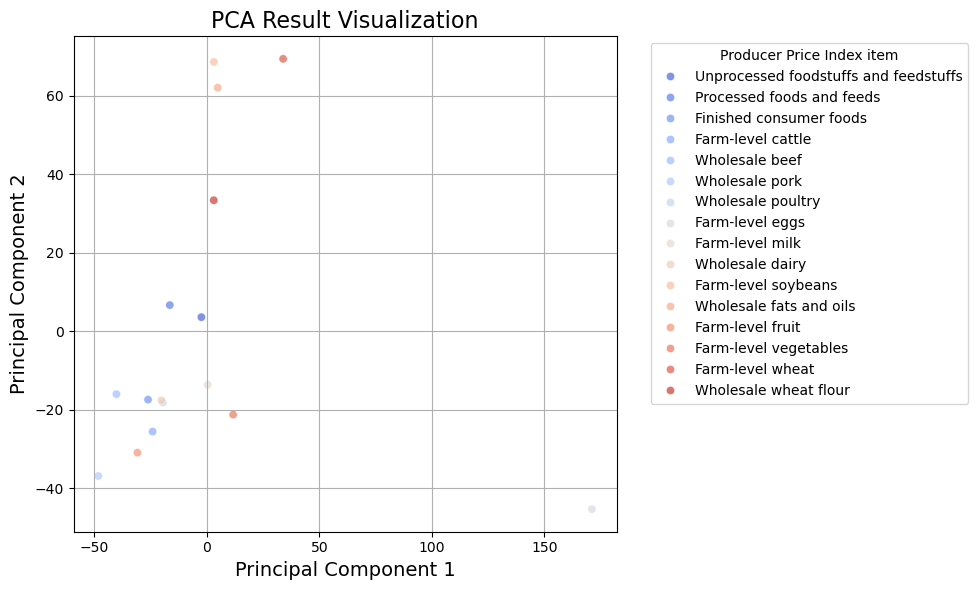

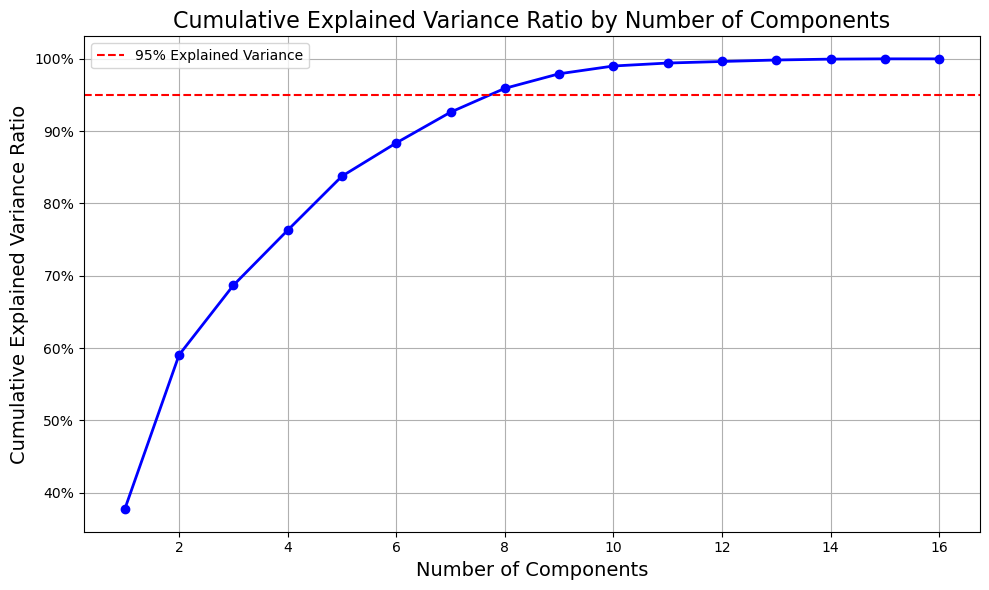

In [257]:
'''PCA Analysis of both DF'''
#PCA analysis for (Year vs Producer Price Index item) and (Producer Price Index item vs Year) respectively
display(yearIndexdf)
pcaAnalysis(yearIndexdf,'Year',list(yearIndexdf.columns.copy())[1:])
display(itemIndexdf)
pcaAnalysis(itemIndexdf,'Producer Price Index item',list(itemIndexdf.columns.copy())[1:])

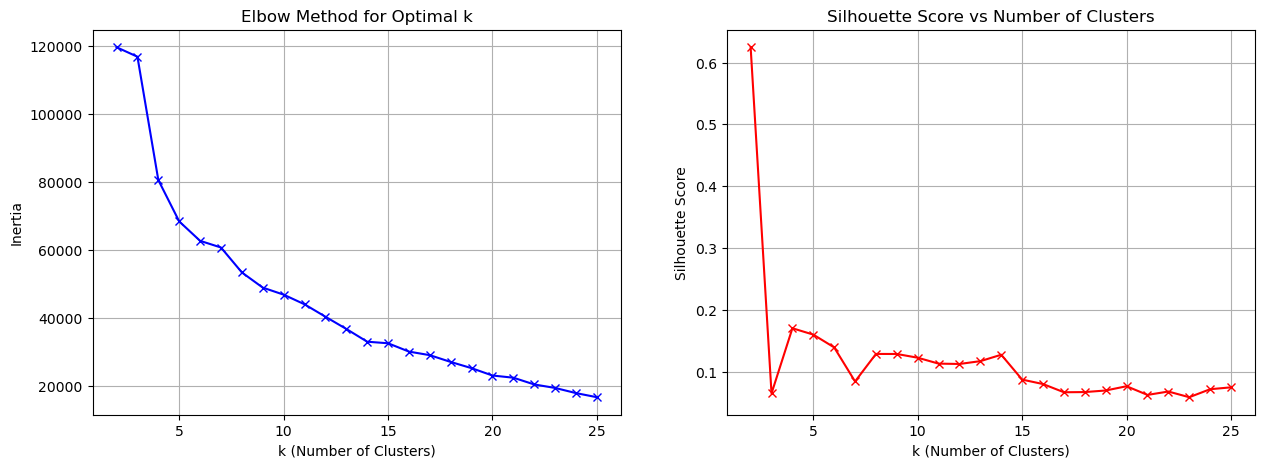

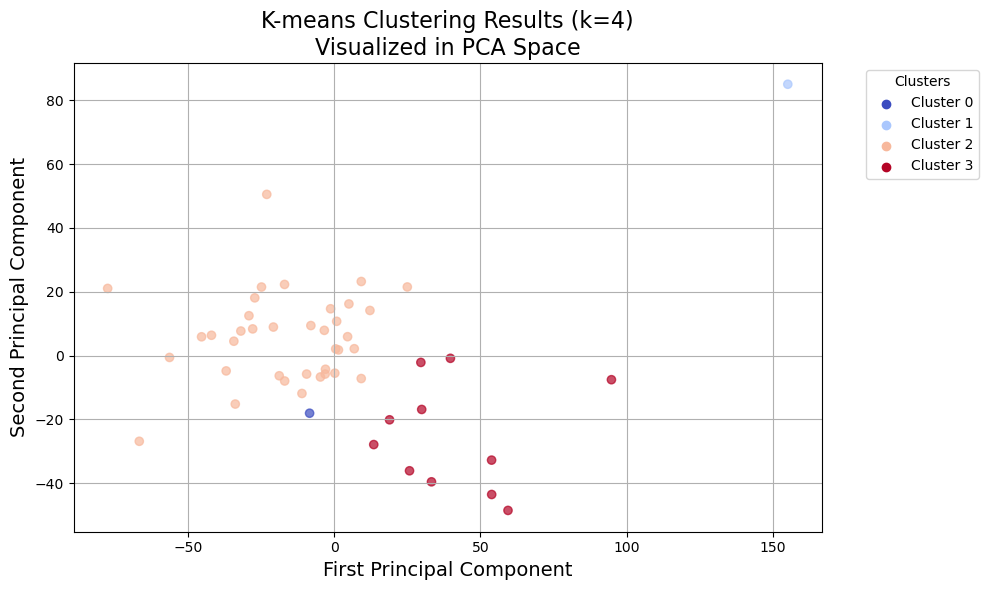


Cluster Sizes:
Cluster
0     1
1     1
2    37
3    11
Name: count, dtype: int64

Cluster Centers (Standardized Features):
           Unprocessed foodstuffs and feedstuffs  Processed foods and feeds  \
Cluster 0                              -3.136000                  -3.138000   
Cluster 1                              23.964000                  11.262000   
Cluster 2                              -4.254919                  -2.989351   
Cluster 3                              12.418545                   9.316545   

           Finished consumer foods  Farm-level cattle  Wholesale beef  \
Cluster 0                -3.806000          -3.394000       -5.762000   
Cluster 1                10.994000          15.006000       -8.562000   
Cluster 2                -1.227622          -2.677784       -2.037676   
Cluster 3                 3.475818           7.951455        8.156182   

           Wholesale pork  Wholesale poultry  Farm-level eggs  \
Cluster 0      -15.272000          -2.258000     

In [271]:
'''KMeans Clustering of Year Indexed DF'''
features = list(yearIndexdf.columns.copy())[1:]
kmeansStats(yearIndexdf,features=features)
#Optimal should be k=4 or k=5 according to inertia and silhouette score plots
mymodel = kmodel(yearIndexdf, features=features, optimal_k=4)

In [ ]:
'''Additional analysis will go here'''
#Testing model out with classification?
#Spectral clustering and how it compares to Kmeans?
#DBSCAN vs Kmeans
